In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

In [3]:
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import nawrapper as nw
import nawrapper.maptools as maptools

In [4]:
nside = 256
lmax = nside * 3 - 1
B_ell = hp.sphtfunc.gauss_beam(np.deg2rad(0.5), lmax=lmax)

(0.0, 1.1)

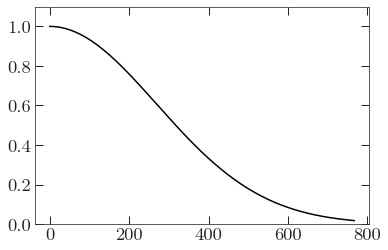

In [5]:
plt.plot(B_ell, '-')
plt.ylim(0.0, 1.1)

In this notebook we will assume a half-degree beam, and we let `synfast` apply the `pixwin` as well.

We create the *true* power and noise spectra.

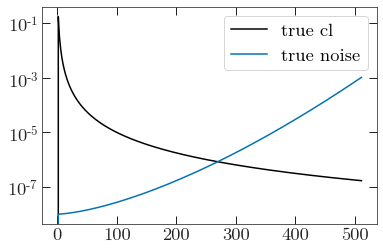

In [6]:
ells = np.arange(0,lmax)
cl = np.zeros(len(ells))
cl[2:] = 1/ells[2:]**2.5 # don't want monopole/dipole
nl = np.exp( (ells / 100)**1.5 ) / 1e8
nl[0:2] = 0.0
window_func = hp.sphtfunc.pixwin(nside=nside)

plt.plot(cl[:2*nside], '-', label='true cl')
plt.plot(nl[:2*nside], '-', label='true noise')
plt.yscale('log')
plt.legend()

In [7]:
def get_maps():
    # apply the pixel window transfer function (pixwin=True)
    m = hp.synfast(B_ell[:lmax]**2 * cl, nside, verbose=False, pixwin=True)
    n1 = hp.synfast(B_ell[:lmax]**2 * nl, nside, verbose=False, pixwin=True)
    n2 = hp.synfast(B_ell[:lmax]**2 * nl,nside, verbose=False, pixwin=True)
    m1 = nw.namap_hp(maps=(m + n1, None, None), 
                  beams=B_ell, verbose=False, unpixwin=True)
    m2 = nw.namap_hp(maps=(m + n2, None, None), 
                  beams=B_ell, verbose=False, unpixwin=True)
    return m1, m2

def get_spec():
    m1, m2 = get_maps()
    return nw.compute_spectra(m1, m2, lmax=lmax, verbose=False)['TT']

In [8]:
from tqdm import tqdm
samples = [get_spec() for i in tqdm(range(50))]

100%|██████████| 50/50 [03:17<00:00,  3.95s/it]


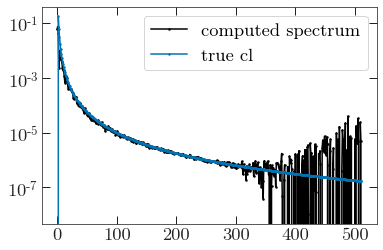

In [9]:
plt.plot( samples[2][:2*nside], label='computed spectrum' )
plt.plot(cl[:2*nside], label='true cl')
plt.legend()
plt.yscale('log')

In [10]:
m1, m2 = get_maps()

mc = nw.mode_coupling(m1, m2, bins=nw.get_unbinned_bins(lmax-1, nside=nside))
cov = nw.nacov(m1, m2, mc)
cov.compute()

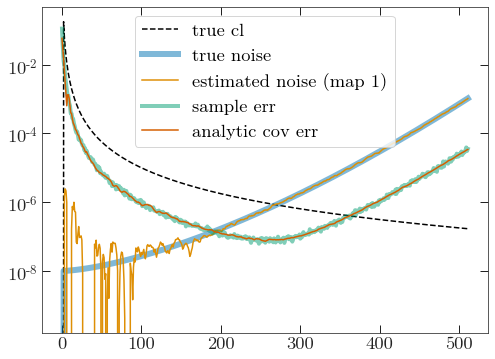

In [11]:
plt.figure(figsize=(8,6))

plt.plot(cl[:2*nside], '--', label='true cl')
plt.plot(nl[:2*nside], '-', label='true noise', alpha=0.5, lw=6)
plt.plot(cov.noise['TT_1'][:2*nside], '-', label='estimated noise (map 1)')
plt.plot( np.std(samples, axis=0)[:2*nside], '-', lw=4, alpha=0.5, label='sample err')
plt.plot( np.sqrt(np.diag(cov.covar_TT_TT))[:2*nside], "-", label='analytic cov err')
plt.legend()
plt.yscale('log')

# Different Noise Levels in Each Map

In [12]:
def get_maps_different():
    # apply the pixel window transfer function (pixwin=True)
    m = hp.synfast(B_ell[:lmax]**2 * cl, nside, verbose=False, pixwin=True)
    n1 = hp.synfast(B_ell[:lmax]**2 * nl, nside, verbose=False, pixwin=True)
    n2 = hp.synfast(B_ell[:lmax]**2 * (nl + 1e-5),nside, verbose=False, pixwin=True)
    m1 = nw.namap_hp(maps=(m + n1, None, None), 
                  beams=B_ell,
                  verbose=False, unpixwin=True)
    m2 = nw.namap_hp(maps=(m + n2, None, None), 
                  beams=B_ell,
                  verbose=False, unpixwin=True)
    return m1, m2

def get_spec_different():
    m1, m2 = get_maps_different()
    return nw.compute_spectra(m1, m2, lmax=lmax, verbose=False)['TT']

In [13]:
m1, m2 = get_maps_different()

In [14]:
from tqdm import tqdm
samples = [get_spec_different() for i in tqdm(range(50))]

100%|██████████| 50/50 [03:16<00:00,  3.94s/it]


In [15]:
m1, m2 = get_maps_different()

mc = nw.mode_coupling(m1, m2, bins=nw.get_unbinned_bins(lmax-1, nside=nside))
cov = nw.nacov(m1, m2, mc)
cov.compute()

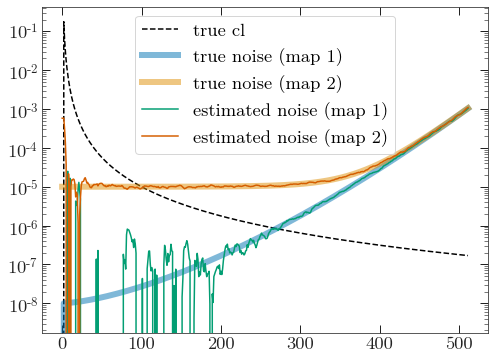

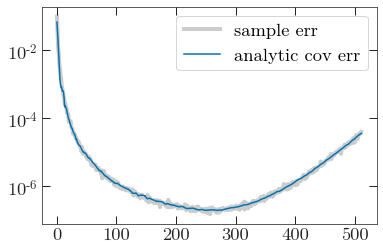

In [16]:
plt.figure(figsize=(8,6))

plt.plot(cl[:2*nside], '--', label='true cl')
plt.plot(nl[:2*nside], '-', label='true noise (map 1)', alpha=0.5, lw=6)
plt.plot(nl[:2*nside] + 1e-5, '-', label='true noise (map 2)', alpha=0.5, lw=6)
plt.plot(cov.noise['TT_1'][:2*nside], '-', label='estimated noise (map 1)')
plt.plot(cov.noise['TT_2'][:2*nside], '-', label='estimated noise (map 2)')
plt.legend()
plt.yscale('log')

plt.figure()
plt.plot( np.std(samples, axis=0)[:2*nside], '-', lw=4, alpha=0.2, label='sample err')
plt.plot( np.sqrt(np.diag(cov.covar_TT_TT))[:2*nside], "-", label='analytic cov err')
plt.legend()
plt.yscale('log')